# Load MSRA data(depth image) and show keypoint annotations

In [1]:
import matplotlib as plt
import msra_data
import open3d as o3
import numpy as np
import matplotlib.pyplot as plt

plt.ion()   # interactive mode

## 1. Open3d examples

In [2]:
# generate some neat n times 3 matrix using a variant of sync function
x = np.linspace(-3, 3, 401)
mesh_x, mesh_y = np.meshgrid(x,x)
z = np.sinc((np.power(mesh_x,2)+np.power(mesh_y,2)))
z_norm = (z-z.min())/(z.max()-z.min())
xyz = np.zeros((np.size(mesh_x),3))
xyz[:,0] = np.reshape(mesh_x,-1)
xyz[:,1] = np.reshape(mesh_y,-1)
xyz[:,2] = np.reshape(z_norm,-1)
print('xyz')
print(xyz)

xyz
[[-3.         -3.          0.17846472]
 [-2.985      -3.          0.17440115]
 [-2.97       -3.          0.17063709]
 ...
 [ 2.97        3.          0.17063709]
 [ 2.985       3.          0.17440115]
 [ 3.          3.          0.17846472]]


In [3]:
# Draw point cloud
# Pass xyz to Open3D.PointCloud and visualize
pcd = o3.PointCloud()
pcd.points = o3.Vector3dVector(xyz)
o3.draw_geometries([pcd])

In [5]:
# Draw Image
img = o3.Image((z_norm*255).astype(np.uint8))
o3.draw_geometries([img])

In [4]:
# Draw mesh etc
def mydraw():

    print("Let\'s draw some primitives")
    mesh_sphere = o3.create_mesh_sphere(radius = 1.0)
    mesh_sphere.compute_vertex_normals()
    mesh_sphere.paint_uniform_color([0.1, 0.1, 0.7])
    mesh_cylinder = o3.create_mesh_cylinder(radius = 0.3, height = 4.0)
    mesh_cylinder.compute_vertex_normals()
    mesh_cylinder.paint_uniform_color([0.1, 0.9, 0.1])
    mesh_frame = o3.create_mesh_coordinate_frame(size = 0.6, origin = [-2, -2, -2])

    print("We draw a few primitives using collection.")
    o3.draw_geometries([mesh_sphere, mesh_cylinder, mesh_frame])

    print("We draw a few primitives using + operator of mesh.")
    o3.draw_geometries([mesh_sphere + mesh_cylinder + mesh_frame])

    print("Let\'s draw a cubic that consists of 8 points and 12 lines")
    points = [[0,0,0],[1,0,0],[0,1,0],[1,1,0],
              [0,0,1],[1,0,1],[0,1,1],[1,1,1]]
    lines = [[0,1],[0,2],[1,3],[2,3],
             [4,5],[4,6],[5,7],[6,7],
             [0,4],[1,5],[2,6],[3,7]]
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set = o3.LineSet()
    line_set.points = o3.Vector3dVector(points)
    line_set.lines = o3.Vector2iVector(lines)
    line_set.colors = o3.Vector3dVector(colors)
    o3.draw_geometries([line_set])
    
mydraw()

Let's draw some primitives
We draw a few primitives using collection.
We draw a few primitives using + operator of mesh.
Let's draw a cubic that consists of 8 points and 12 lines


## 2. View MSRA training data

In [2]:
def show_cloud(points):
    pcd = o3.PointCloud()
    pcd.points = o3.Vector3dVector(points)
    o3.draw_geometries([pcd])

    
def show_depth_image(img):
    '''Show depth image with Open3D'''
    img1 = img.copy()
    d_min = np.min(img1)
    d_max = np.max(img1)
    img1[img1 == d_max] = d_min  # Set largest value to min(since background depth is largest)
    d_max = np.max(img1)

    img_norm = (img1 - d_min) / (d_max - d_min) * 255
    img2 = o3.Image(img_norm.astype(np.uint8))
    o3.draw_geometries([img2])

    
def show_keypoints(points):
    spheres = []
    num = points.shape[0]
    for i in range(num):
        ms = o3.create_mesh_sphere(radius = 1.0)
        ms.compute_vertex_normals()
        ms.paint_uniform_color([0.1, 0.1, 0.7])
        transform_vertices = o3.Vector3dVector(np.asarray(ms.vertices) + points[i]) # ??
        ms.vertices = transform_vertices
        spheres.append(ms)
    o3.draw_geometries(spheres)

    
def show_cloud_keypoints(cloud, points):
    points = points.copy()
    objects = []
    
    pcd = o3.PointCloud()
    pcd.points = o3.Vector3dVector(cloud)
    
    objects.append(pcd)

    num = points.shape[0]
    for i in range(num):
        ms = o3.create_mesh_sphere(radius = 3.0)
        ms.compute_vertex_normals()
        ms.paint_uniform_color([0.1, 0.1, 0.1])
        transform_vertices = o3.Vector3dVector(np.asarray(ms.vertices) + points[i])
        ms.vertices = transform_vertices
        objects.append(ms)
    
    o3.draw_geometries(objects)

    
def show_cloud_keypoints1(cloud, points):
    pcd = o3.PointCloud()
    pcd.points = o3.Vector3dVector(cloud)
    
    pcd1 = o3.PointCloud()
    pcd1.points = o3.Vector3dVector(points)
    pcd1.paint_uniform_color([0.0, 1.0, 0.0])
    
    o3.draw_geometries([pcd, pcd1])

    
def show_landmarks(image, landmarks, norm_image=True):
    """Show image with landmarks"""
    img = image.copy()
    if norm_image:
        maxv = img.max()
        minv = img.min()
    
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated
 
    
def better_visulaization_depth_image(img):
    img1 = img.copy()
    d_min = np.min(img1)
    d_max = np.max(img1)
    
    # move background pixel values closer to true/better largest depth value
    img1[img1 == d_max] = d_min
    d_max = np.max(img1)
    img1[img1 == d_min] = d_max
    
    return img1


def build_spheres(points, colors, radius=1.0):
    points = points.copy()
    spheres = []
    num = points.shape[0]
    for i in range(num):
        ms = o3.create_mesh_sphere(radius)
        ms.compute_vertex_normals()
        ms.paint_uniform_color(colors[i])
        transform_vertices = np.asarray(ms.vertices) + points[i] # Bug exist here!!?
        ms.vertices = o3.Vector3dVector(transform_vertices)
        spheres.append(ms)
    return spheres
        

def build_msra_joints_geo(joints_3d):
    '''
    joints_3d: (21, 3)
    
    --1(wrist)
    --2(index_mcp), 3(index_pip), 4(index_dip), 5(index_tip)
    --6(middle_mcp), 7(middle_pip), 8(middle_dip), 9(middle_tip)
    --10(ring_mcp), 11(ring_pip), 12(ring_dip), 13(ring_tip)
    --14(little_mcp), 15(little_pip), 16(little_dip), 17(little_tip)
    --18(thumb_mcp), 19(thumb_pip), 20(thumb_dip), 21(thumb_tip)
    '''
    lines = [[1, 18], [18, 19], [19, 20], [20, 21],
             [1, 2], [2, 3], [3, 4], [4, 5],
             [1, 6], [6, 7], [7, 8], [9, 9],
             [1, 10], [10, 11], [11, 12], [12, 13],
             [1, 14], [14, 15], [15, 16], [16, 17]]
    for l in lines:
        l[0] -= 1
        l[1] -= 1
    
    line_colors = [[255/255,153/255,153/255], [255/255,102/255,102/255], [255/255,51/255,51/255], [255/255,0/255,0/255],
                   [153/255,255/255,153/255], [102/255,255/255,102/255], [51/255,255/255,51/255], [0/255,255/255,0/255],
                   [255/255,204/255,153/255], [255/255,178/255,102/255], [255/255,153/255,51/255], [255/255,128/255,0/255],
                   [153/255,204/255,255/255], [102/255,178/255,255/255], [51/255,153/255,255/255], [0/255,128/255,255/255],
                   [255/255,153/255,255/255], [255/255,102/255,255/255], [255/255,51/255,255/255], [255/255,0/255,255/255]
                  ]
    
    point_colors = [[230/255, 230/255, 0/255],
                    [153/255, 255/25, 153/255], [102/255, 255/255, 102/255], [51/255, 255/255, 51/255], [0/255, 255/255, 0/255],
                    [255/255, 204/255, 153/255], [255/255, 178/255, 102/255], [255/255, 153/255, 51/255], [255/255, 128/255, 0/255],
                    [153/255, 204/255, 255/255], [102/255, 178/255, 255/255], [51/255, 153/255, 255/255], [0/255, 128/255, 255/255],
                    [255/255, 153/255, 255/255], [255/255, 102/255, 255/255], [255/255, 51/255, 255/255], [255/255, 0/255, 255/255],
                    [255/255, 153/255, 153/255], [255/255, 102/255, 102/255], [255/255, 51/255, 51/255], [255/255, 0/255, 0/255]
                   ]
    
    joint_3d = joints_3d.copy() # Bug, if do not copy, there will be shift

    
    line_set = o3.LineSet()
    line_set.points = o3.Vector3dVector(joints_3d)
    line_set.lines = o3.Vector2iVector(lines)
    line_set.colors = o3.Vector3dVector(line_colors)

        
    joints = build_spheres(joint_3d, point_colors, 3.0)
    
    #return joints
    return [line_set] + joints


def show_cloud_keypoints_better(cloud, points):    
    pcd = o3.PointCloud()
    pcd.points = o3.Vector3dVector(cloud)
    
    joints = build_msra_joints_geo(points)
    
    o3.draw_geometries([pcd] + joints)

In [97]:
# Load training data
data_t = msra_data.load_data('train')
#data = msra_data.load_data('test')

joint_world_t, ref_pt_t, names_t = data_t
print('joint_world.shape: {}'.format(joint_world_t.shape))

training data loading...
#train_size: 67893
#test_size: 8498
db_type: train
#ref_pt_str: 67893
file_id: 67893
frame_id: 67893
joint_world.shape: (67893, 21, 3)


depth_name:  /home/maiqi/yalong/dataset/cvpr15_MSRAHandGestureDB/P0/Y/000001_depth.bin
img.shape: (240, 320)


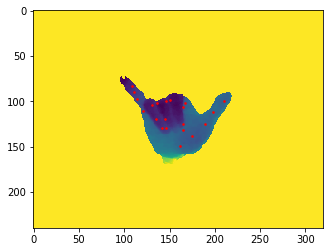

In [106]:
# Show landmarks
fid_t = 8000

# Get depth image
img_name_t = names_t[fid_t]
print('depth_name: ', img_name_t)

img_t = msra_data.load_depthmap(img_name_t)
print('img.shape: {}'.format(img_t.shape))

# Get landmarks
joints_3d_t = joint_world_t[fid_t].copy()

# For better visualization of depth image
img1_t = better_visulaization_depth_image(img_t)

# Convert depth image to 3d points cloud
depth_cloud_t = msra_data.depthmap2cloud(img1_t)


#show_cloud_keypoints(depth_cloud_t.reshape(-1, 3), joints_3d_t)
show_cloud_keypoints_better(depth_cloud_t.reshape(-1, 3), joints_3d_t)


# Show reference point
#show_cloud_keypoints(depth_cloud_t.reshape(-1, 3), ref_pt_t[fid_t].reshape(1, 3))

# Show 2d joints with depth image
joints_2d_t = msra_data.cloud2pixels(joints_3d_t)
show_landmarks(img1_t, joints_2d_t)

## 3. Show test result

In [3]:
# Load test data
data = msra_data.load_data('test')

joint_world, ref_pt, names = data
print('joint_world.shape: {}'.format(joint_world.shape))

testing data loading...
#train_size: 67893
#test_size: 8498
db_type: test
#ref_pt_str: 8498
file_id: 8498
frame_id: 8498
joint_world.shape: (8498, 21, 3)


In [4]:
# Load test result
#res_2d = np.loadtxt('./result.txt')
#res_3d = np.loadtxt('./result_world.txt')

res_2d = np.loadtxt('./au_result_s3_ep13.txt')
res_3d = np.loadtxt('./au_result_world_s3_ep13.txt')

res_2d = res_2d.reshape(-1, 21, 3)
res_3d = res_3d.reshape(-1, 21, 3)
print('res_2d.shape: {}'.format(res_2d.shape))
print('res_2d.shape: {}'.format(res_3d.shape))


assert(res_2d.shape[0] == joint_world.shape[0])

res_2d.shape: (8498, 21, 3)
res_2d.shape: (8498, 21, 3)


depth_img_name:  /home/maiqi/yalong/dataset/cvpr15_MSRAHandGestureDB/P3/5/000132_depth.bin
img.shape: (240, 320)


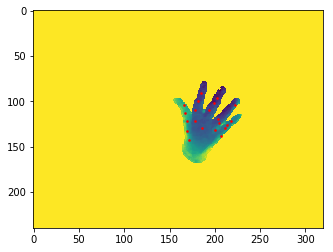

In [6]:
# Show 3d hand point cloud and estimated joints
fid = 2132

# Load depth image, joint_2d, joint_3d, reference point
img_name = names[fid]
joints_2d = res_2d[fid].copy()
joints_3d = res_3d[fid].copy()
rp = ref_pt[fid].copy().reshape(1, 3)

# depth image
img = msra_data.load_depthmap(img_name)
img = better_visulaization_depth_image(img)

# 3d cloud
depth_cloud = msra_data.depthmap2cloud(img).reshape(-1, 3)
#show_cloud(depth_cloud.reshape(-1, 3))


print('depth_img_name: ', img_name)
print('img.shape: {}'.format(img.shape))

# Show
#show_cloud_keypoints(depth_cloud, rp)

#show_cloud_keypoints(depth_cloud, joints_3d)
show_cloud_keypoints_better(depth_cloud, joints_3d)


show_landmarks(img, joints_2d)

## 4. Show author's direct result

In [111]:
# Note, this result contains all samples result(all folders)
# Load author's test result
au_res_2d = np.loadtxt('./author_result_pixel_all.txt')
au_res_3d = np.loadtxt('./author_result_world_all.txt')

au_res_2d = au_res_2d.reshape(-1, 21, 3)
au_res_3d = au_res_3d.reshape(-1, 21, 3)
print('au_res_2d.shape: {}'.format(au_res_2d.shape))
print('aU_res_2d.shape: {}'.format(au_res_3d.shape))

print('train + test: ', msra_data.msra_data_config['train_size'] + msra_data.msra_data_config['test_size'])

au_res_2d.shape: (76391, 21, 3)
aU_res_2d.shape: (76391, 21, 3)
train + test:  76391


depth_img_name:  /home/maiqi/yalong/dataset/cvpr15_MSRAHandGestureDB/P0/1/000444_depth.bin
img.shape: (240, 320)


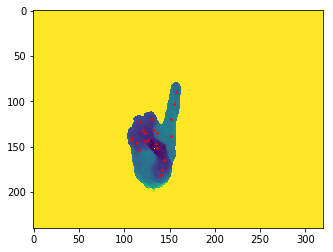

In [120]:
# Current test_model = 3
# And train and test datasets only contain parts of all samples(because leave-one-subject-out cross-validation)
# So, we show some front samples in training datasets(e.g less than 500*3?)


# Show 3d hand point cloud and estimated joints
fid = 444

# Load depth image, joint_2d, joint_3d, reference point
img_name = names_t[fid]
joints_2d = au_res_2d[fid].copy()
joints_3d = au_res_3d[fid].copy()
rp = ref_pt_t[fid].copy().reshape(1, 3)

# depth image
img = msra_data.load_depthmap(img_name)
img = better_visulaization_depth_image(img)

# 3d cloud
depth_cloud = msra_data.depthmap2cloud(img).reshape(-1, 3)

print('depth_img_name: ', img_name)
print('img.shape: {}'.format(img.shape))

# Show
#show_cloud_keypoints(depth_cloud, joints_3d)
show_cloud_keypoints_better(depth_cloud, joints_3d)

show_landmarks(img, joints_2d)